In [18]:
%%capture

# NOT NEEDED IF YOU ARE IN BINDER
import sys
!{sys.executable} -m pip install quantum-image-classifier==1.0.0

# Quantum image classifier
## Package usage

If you want to use this package you can install it using `pip install quantum-image-classifier`, just as we did on the top of this notebook. After that, you can easily import it as any other package.

In [2]:
import quantum_image_classifier

## Features
In this package you can do three things: treat data to feed into the algorithm, call a quantum algorithm to classify the data and visualize the accuracy or the points of the dataset. We see how in the next sections.

### Data treatment
You can obtain the data you want to test the algorithms in this section of the package. First of all, you can generate synthetic data by using the function `generate_synthetic_data` like we show you here.

In [3]:
from quantum_image_classifier import data_generator as dg

n_dim = 8
n_clusters = 2
n_samples = 1000

train_X_syn, train_y_syn, test_X_syn, test_y_syn = dg.generate_synthetic_data(n_dim, n_clusters, n_samples)

Other option is to use the MNIST dataset. To do this you need to be aware of a very important aspect of the nature of the quantum algorithms: **you can operate with a very limited number of qubits**. This means that, if you wish to classify an actual image, you need to preprocess it before applying the algorithms in order to reduce its dimensionality and be able to use the data (we recommend this to data with a dimension greater than 32). To do this to the MNIST dataset you can use one of the three options we give you:

1. **Use PCA (PCA).** You can use PCA method to achieve a dimension reduction. The only problem this method has is that you have to assume a linear relationship between the input and the output, so, if there is a non-linear relationship, you can generate non-accurate data.
2. **Use simple autoencoder (AE).** You can use a simple autoencoder in order to achieve a dimension reduction. This solves the non-linear cases, but increases the execution time, because you have to train a neural network.
3. **Use autoencoder based on CNN (AE_CNN).** With this less simple implementation of the autoencoder you will achieve much more accuracy than with the simple autoencoder by trading time of execution and complexity.

You have an example of how can you apply this preprocess to the data below, using the function `get_MNIST`.

In [ ]:
from quantum_image_classifier import data_loader as dl

# It will take time to compute this operations.

train_X_pca, train_y_pca, test_X_pca, test_y_pca = dl.get_MNIST(8, "PCA")
print("PCA PREPROCESS")
print(train_X_pca[:10])

train_X_ae, train_y_ae, test_X_ae, test_y_ae = dl.get_MNIST(8, "AE")
print("SIMPLE AUTOENCODER PREPROCESS")
print(train_X_ae[:10])

train_X_ae_cnn, train_y_ae_cnn, test_X_ae_cnn, test_y_ae_cnn = dl.get_MNIST(8, "AE_CNN")
print("CNN AUTOENCODER PREPROCESS")
print(train_X_ae_cnn[:10])

### Algorithms
#### Nearest centroid algorithm
In order to use this algorithm, first we need to instance the class NearestCentroid. We can instance this class in two ways: either by giving the training set as an argument (along with the dimension of the data points and the labels associated to this dataset) or empty. In the first way, we will need to send the dataset with the associated labels to the function `fit`.

In [6]:
from quantum_image_classifier import NearestCentroid

# Empty instance
nearest_centroid = NearestCentroid()
nearest_centroid.fit(train_X_syn, train_y_syn, n_dim)
labels_predicted = nearest_centroid.predict(test_X_syn)

print(test_y_syn[:20])
print(labels_predicted[:20])

[0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1]
[0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1]


On the contrary, if we have already given the dataset with its associated labels on the construction, we just need to call fit wthout arguments. By the way, if you call here `fit` with arguments, then you will override the data of the construction, naturally.

In [7]:
# Instance with dataset and labels
nearest_centroid = NearestCentroid(train_X_syn, train_y_syn, n_dim)
nearest_centroid.fit()
labels_predicted = nearest_centroid.predict(test_X_syn)

print(test_y_syn[:20])
print(labels_predicted[:20])

[0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1]
[0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1]


### Visual representation

In this package we also implement a module to visualize the accuracy of the methods, we just need to execute the nearest centroid algorithm as we did above and calculate the percetages of accuracy like we show below.

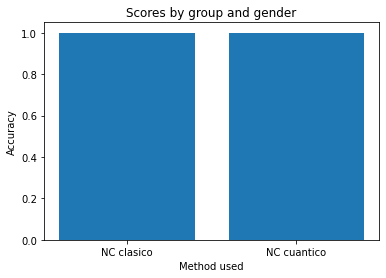

In [8]:
from sklearn.neighbors import NearestCentroid as classicalNC
from quantum_image_classifier import NearestCentroid as quantumNC

from quantum_image_classifier import error_graph

def _calc_accuracy(labels, predictions):
    counts = 0
    for label, prediction in zip(labels, predictions):
        if prediction == label:
            counts += 1
    return counts / len(labels)

quantum = quantumNC()
quantum.fit(train_X_syn, train_y_syn, n_dim)
labelsQ = quantum.predict(test_X_syn)

classical = classicalNC()
classical.fit(train_X_syn, train_y_syn)
labelsC = classical.predict(test_X_syn)

accuracyQ = _calc_accuracy(test_y_syn, labelsQ)
accuracyC = _calc_accuracy(test_y_syn, labelsC)

error_graph("./clasico_vs_cuantico_gen.png",
                 ("NC clasico", accuracyC), ("NC cuantico", accuracyQ))

To complement this, due to the stochastic nature of the quantum algorithms, we have also created a function which shows the same as before, buf of several simulations, representing the average and the standard deviation of the result in order to get a real impression on which is the actual performance of the algorithm.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:44<00:00,  2.23s/it]


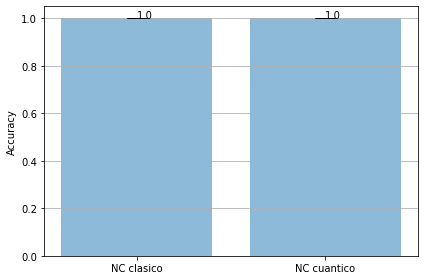

In [10]:
from quantum_image_classifier import variance_error_graph
from tqdm import tqdm

accuracyQ = []
accuracyC = []

for _ in tqdm(range(20)):
    quantum = quantumNC()
    quantum.fit(train_X_syn, train_y_syn, n_dim)
    labelsQ = quantum.predict(test_X_syn)

    classical = classicalNC()
    classical.fit(train_X_syn, train_y_syn)
    labelsC = classical.predict(test_X_syn)

    accuracyQ.append(_calc_accuracy(test_y_syn, labelsQ))
    accuracyC.append(_calc_accuracy(test_y_syn, labelsC))
    
# The plot will be saved in the directory of the notebook with this name
variance_error_graph("./clasico_vs_cuantico_gen.png",
                     ("NC clasico", accuracyC), ("NC cuantico", accuracyQ))

On the other hand, we also have implemented a function to visualize a cloud point plot in case the dimension of the data points is equal to 2.

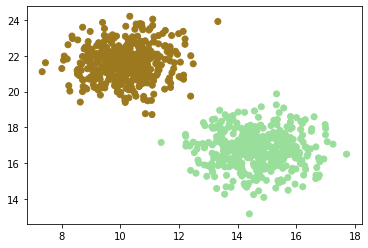

<Figure size 432x288 with 0 Axes>

In [11]:
from quantum_image_classifier import cloud_point

n_clusters = 2
cloud_point(train_X_syn, train_y_syn, "./cloud_point_gen.png", n_clusters)

## Experiments

This package is a result of a End of Degree project in which we tested the algorithm in different ways. First, we showed how well we were estimating the distance using the synthetic data and the real data. Second, we tested the quantum nearest centroid against its classical version by measuring its accuracy through a certain number of iterations and using, again, both the real data from MNIST and the synthetic data. Third, and last, we also showed how the reduction methods and the number of clusters affected the classffication task, once again, taking both types of data into consideration.

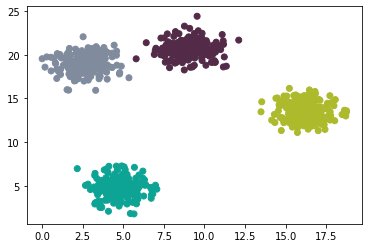

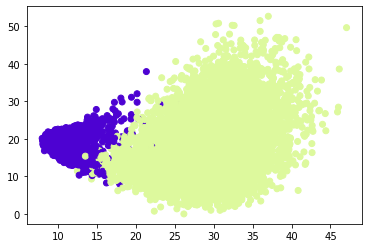

Generado: MEDIA 12.99390059455511 DIFERENCIA 0.026818417428144024
MNIST: MEDIA 13.352860415396032 DIFERENCIA 0.11142364457760548


<Figure size 432x288 with 0 Axes>

In [16]:
from quantum_image_classifier import data_generator, data_loader
import numpy as np

# TEST OF QUANTUM DISTANCE WITH CLOUD POINT PLOT
def distanceComparison():
    n_dim = 2
    n_clusters = 4
    train_X, train_y, test_X, test_y = data_generator.generate_synthetic_data(
        n_dim, n_clusters, 1000)
    cloud_point(train_X, train_y, "./cloud_point_gen.png", n_clusters)

    quantum = quantumNC()
    quantum.fit(train_X, train_y, n_dim)
    labels, differenceGen, distanceGen = quantum.predict(test_X, test_distance=True)

    train_X, train_y, test_X, test_y = data_loader.get_MNIST(n_dim, "PCA", [0,1])
    cloud_point(train_X, train_y, "./could_point_MNIST.png", n_clusters)

    quantum = quantumNC()
    quantum.fit(train_X, train_y, n_dim)
    labels, differenceMNIST, distanceMNIST = quantum.predict(test_X, test_distance=True)

    print("Generado: MEDIA {} DIFERENCIA {}".format(np.mean(distanceGen), np.mean(np.absolute(differenceGen))))
    print("MNIST: MEDIA {} DIFERENCIA {}".format(np.mean(distanceMNIST), np.mean(np.absolute(differenceMNIST))))

distanceComparison()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]


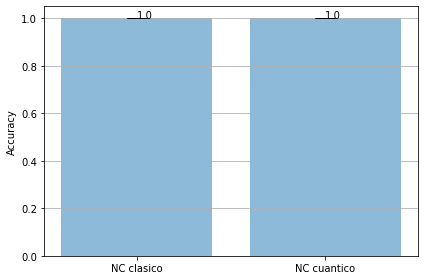

In [13]:
# COMPARISON BETWEEN CLASSIC AND QUANTUM PERFORMANCE WITH SYNTHETIC DATA
def quantumVSclasico_gen(iterations):
    n_dim = 8
    n_clusters = 2
    accuracyQ = []
    accuracyC = []

    for _ in tqdm(range(iterations)):
        train_X, train_y, test_X, test_y = data_generator.generate_synthetic_data(
            n_dim, n_clusters, 1000)

        quantum = quantumNC()
        quantum.fit(train_X, train_y, n_dim)
        labelsQ = quantum.predict(test_X)

        classical = classicalNC()
        classical.fit(train_X, train_y)
        labelsC = classical.predict(test_X)

        accuracyQ.append(_calc_accuracy(test_y, labelsQ))
        accuracyC.append(_calc_accuracy(test_y, labelsC))

    variance_error_graph("./clasico_vs_cuantico_gen.png",
                         ("NC clasico", accuracyC), ("NC cuantico", accuracyQ))
quantumVSclasico_gen(5)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:29<00:00, 89.99s/it]


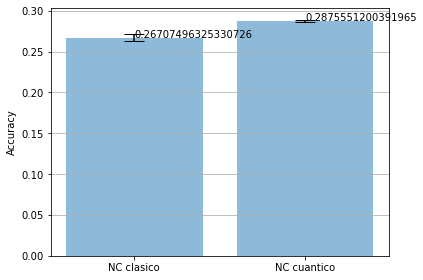

In [14]:
# COMPARISON BETWEEN CLASSIC AND QUANTUM PERFORMANCE WITH MNIST DATA
def quantumVSclassic_MNIST(iterations):
    n_dim = 8
    n_clusters = 2
    accuracyQ = []
    accuracyC = []

    for _ in tqdm(range(iterations)):
        train_X, train_y, test_X, test_y = data_loader.get_MNIST(n_dim, "PCA", [
                                                                 1, 0, 6, 9])

        quantum = quantumNC()
        quantum.fit(train_X, train_y, n_dim)
        labelsQ = quantum.predict(test_X)

        classical = classicalNC()
        classical.fit(train_X, train_y)
        labelsC = classical.predict(test_X)

        accuracyQ.append(_calc_accuracy(test_y, labelsQ))
        accuracyC.append(_calc_accuracy(test_y, labelsC))

    variance_error_graph("./clasico_vs_cuantico_MNIST.png",
                         ("NC clasico", accuracyC), ("NC cuantico", accuracyQ))
quantumVSclassic_MNIST(5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [29:04<00:00, 348.99s/it]


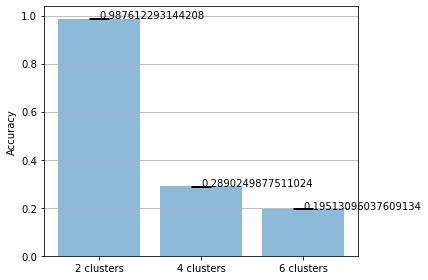

In [15]:
# COMPARISON BETWEEN NUMBER OF CLUSTERS
def numClustersAccuracy(iterations):
    n_dim = 8
    accuracy2 = []
    accuracy4 = []
    accuracy6 = []

    for _ in tqdm(range(iterations)):
        train_X, train_y, test_X, test_y = data_loader.get_MNIST(n_dim, "PCA", [
                                                                 1, 0])
        quantum = quantumNC()
        quantum.fit(train_X, train_y, n_dim)
        accuracy2.append(_calc_accuracy(test_y, quantum.predict(test_X)))

        train_X, train_y, test_X, test_y = data_loader.get_MNIST(n_dim, "PCA", [
                                                                 1, 0, 6, 9])
        quantum = quantumNC()
        quantum.fit(train_X, train_y, n_dim)
        accuracy4.append(_calc_accuracy(test_y, quantum.predict(test_X)))

        train_X, train_y, test_X, test_y = data_loader.get_MNIST(
            n_dim, "PCA", [1, 0, 4, 5, 6, 9])
        quantum = quantumNC()
        quantum.fit(train_X, train_y, n_dim)
        accuracy6.append(_calc_accuracy(test_y, quantum.predict(test_X)))

    variance_error_graph("./clusters_accuracy.png",
                         ("2 clusters", accuracy2), ("4 clusters", accuracy4), ("6 clusters", accuracy6))
    
numClustersAccuracy(5)


  0%|                                                                                                              | 0/5 [00:00<?, ?it/s]

Epoch 1/20
96/96 [==============================] - 2s 10ms/step - loss: 0.4310 - val_loss: 0.2619
Epoch 2/20
96/96 [==============================] - 1s 8ms/step - loss: 0.2375 - val_loss: 0.2207
Epoch 3/20
96/96 [==============================] - 1s 8ms/step - loss: 0.2110 - val_loss: 0.2003
Epoch 4/20
96/96 [==============================] - 1s 8ms/step - loss: 0.1922 - val_loss: 0.1830
Epoch 5/20
96/96 [==============================] - 1s 8ms/step - loss: 0.1772 - val_loss: 0.1706
Epoch 6/20
96/96 [==============================] - 1s 8ms/step - loss: 0.1670 - val_loss: 0.1625
Epoch 7/20
96/96 [==============================] - 1s 8ms/step - loss: 0.1604 - val_loss: 0.1572
Epoch 8/20
96/96 [==============================] - 1s 8ms/step - loss: 0.1561 - val_loss: 0.1537
Epoch 9/20
96/96 [==============================] - 1s 8ms/step - loss: 0.1529 - val_loss: 0.1508
Epoch 10/20
96/96 [==============================] - 1s 8ms/step - loss: 0.1503 - val_loss: 0.1484
Epoch 11/20
96/96 


 20%|███████████████████▌                                                                              | 1/5 [17:02<1:08:08, 1022.05s/it]

Epoch 1/20
96/96 [==============================] - 1s 8ms/step - loss: 0.4567 - val_loss: 0.2704
Epoch 2/20
96/96 [==============================] - 1s 7ms/step - loss: 0.2391 - val_loss: 0.2200
Epoch 3/20
96/96 [==============================] - 1s 7ms/step - loss: 0.2084 - val_loss: 0.1969
Epoch 4/20
96/96 [==============================] - 1s 7ms/step - loss: 0.1897 - val_loss: 0.1825
Epoch 5/20
96/96 [==============================] - 1s 7ms/step - loss: 0.1771 - val_loss: 0.1718
Epoch 6/20
96/96 [==============================] - 1s 7ms/step - loss: 0.1679 - val_loss: 0.1640
Epoch 7/20
96/96 [==============================] - 1s 7ms/step - loss: 0.1608 - val_loss: 0.1579
Epoch 8/20
96/96 [==============================] - 1s 7ms/step - loss: 0.1557 - val_loss: 0.1536
Epoch 9/20
96/96 [==============================] - 1s 7ms/step - loss: 0.1523 - val_loss: 0.1507
Epoch 10/20
96/96 [==============================] - 1s 7ms/step - loss: 0.1498 - val_loss: 0.1486
Epoch 11/20
96/96 [


 40%|████████████████████████████████████████▍                                                            | 2/5 [26:53<38:25, 768.56s/it]

Epoch 1/20
96/96 [==============================] - 1s 7ms/step - loss: 0.4458 - val_loss: 0.2753
Epoch 2/20
96/96 [==============================] - 1s 6ms/step - loss: 0.2503 - val_loss: 0.2292
Epoch 3/20
96/96 [==============================] - 1s 6ms/step - loss: 0.2181 - val_loss: 0.2063
Epoch 4/20
96/96 [==============================] - 1s 6ms/step - loss: 0.1992 - val_loss: 0.1912
Epoch 5/20
96/96 [==============================] - 1s 6ms/step - loss: 0.1869 - val_loss: 0.1808
Epoch 6/20
96/96 [==============================] - 1s 6ms/step - loss: 0.1780 - val_loss: 0.1737
Epoch 7/20
96/96 [==============================] - 1s 6ms/step - loss: 0.1714 - val_loss: 0.1679
Epoch 8/20
96/96 [==============================] - 1s 6ms/step - loss: 0.1658 - val_loss: 0.1608
Epoch 9/20
96/96 [==============================] - 1s 6ms/step - loss: 0.1577 - val_loss: 0.1548
Epoch 10/20
96/96 [==============================] - 1s 6ms/step - loss: 0.1537 - val_loss: 0.1518
Epoch 11/20
96/96 [


 60%|█████████████████████████████████████████████████████████▌                                      | 3/5 [1:35:51<1:16:54, 2307.30s/it]

Epoch 1/20
96/96 [==============================] - 1s 8ms/step - loss: 0.4419 - val_loss: 0.2754
Epoch 2/20
96/96 [==============================] - 1s 6ms/step - loss: 0.2489 - val_loss: 0.2265
Epoch 3/20
96/96 [==============================] - 1s 6ms/step - loss: 0.2151 - val_loss: 0.2048
Epoch 4/20
96/96 [==============================] - 1s 6ms/step - loss: 0.1950 - val_loss: 0.1862
Epoch 5/20
96/96 [==============================] - 1s 7ms/step - loss: 0.1792 - val_loss: 0.1730
Epoch 6/20
96/96 [==============================] - 1s 7ms/step - loss: 0.1687 - val_loss: 0.1652
Epoch 7/20
96/96 [==============================] - 1s 7ms/step - loss: 0.1627 - val_loss: 0.1604
Epoch 8/20
96/96 [==============================] - 1s 7ms/step - loss: 0.1585 - val_loss: 0.1567
Epoch 9/20
96/96 [==============================] - 1s 7ms/step - loss: 0.1552 - val_loss: 0.1537
Epoch 10/20
96/96 [==============================] - 1s 6ms/step - loss: 0.1525 - val_loss: 0.1514
Epoch 11/20
96/96 [


 80%|██████████████████████████████████████████████████████████████████████████████▍                   | 4/5 [1:45:42<27:09, 1629.68s/it]

Epoch 1/20
96/96 [==============================] - 1s 9ms/step - loss: 0.4443 - val_loss: 0.2674
Epoch 2/20
96/96 [==============================] - 1s 7ms/step - loss: 0.2415 - val_loss: 0.2234
Epoch 3/20
96/96 [==============================] - 1s 7ms/step - loss: 0.2120 - val_loss: 0.1993
Epoch 4/20
96/96 [==============================] - 1s 7ms/step - loss: 0.1898 - val_loss: 0.1802
Epoch 5/20
96/96 [==============================] - 1s 7ms/step - loss: 0.1743 - val_loss: 0.1689
Epoch 6/20
96/96 [==============================] - 1s 7ms/step - loss: 0.1661 - val_loss: 0.1630
Epoch 7/20
96/96 [==============================] - 1s 7ms/step - loss: 0.1611 - val_loss: 0.1586
Epoch 8/20
96/96 [==============================] - 1s 7ms/step - loss: 0.1571 - val_loss: 0.1550
Epoch 9/20
96/96 [==============================] - 1s 7ms/step - loss: 0.1542 - val_loss: 0.1526
Epoch 10/20
96/96 [==============================] - 1s 7ms/step - loss: 0.1520 - val_loss: 0.1507
Epoch 11/20
96/96 [

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [1:56:13<00:00, 1394.79s/it]


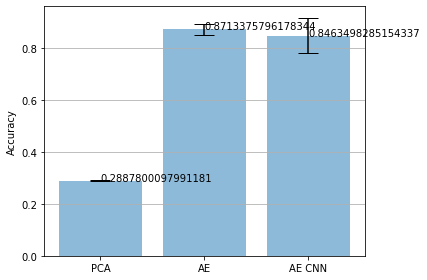

In [17]:
# COMPARISON BETWEEN TYPES OF METHODS FOR DIMENSIONALITY REDUCTION
def reductionMethodAccuracy(iterations):
    n_dim = 8
    accuracyPCA = []
    accuracyAE = []
    accuracyAECNN = []

    for _ in tqdm(range(iterations)):
        train_X, train_y, test_X, test_y = data_loader.get_MNIST(n_dim, "PCA", [
                                                                 1, 0, 6, 9])
        quantum = quantumNC()
        quantum.fit(train_X, train_y, n_dim)
        accuracyPCA.append(_calc_accuracy(test_y, quantum.predict(test_X)))

        train_X, train_y, test_X, test_y = data_loader.get_MNIST(n_dim, "AE", [
                                                                 1, 0, 6, 9])
        quantum = quantumNC()
        quantum.fit(train_X, train_y, n_dim)
        accuracyAE.append(_calc_accuracy(test_y, quantum.predict(test_X)))

        train_X, train_y, test_X, test_y = data_loader.get_MNIST(n_dim, "AE_CNN", [
                                                                 1, 0, 6, 9])
        quantum = quantumNC()
        quantum.fit(train_X, train_y, n_dim)
        accuracyAECNN.append(_calc_accuracy(test_y, quantum.predict(test_X)))

    variance_error_graph("./reduction_accuracy.png",
                         ("PCA", accuracyPCA), ("AE", accuracyAE), ("AE CNN", accuracyAECNN))
reductionMethodAccuracy(5)